<a href="https://colab.research.google.com/github/1roshanekka/resources/blob/main/DEMO_CODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install backtrader
!pip install yfinance

In [ ]:
import backtrader as bt 
import datetime
import yfinance as yf
from matplotlib import pyplot as plt

# ***RSI Strategy***
This is the implementation of a very simple strategy on $GOOGL on the following time frame: Jan 1 2019 - Dec 31 2020. We buy the stock whenever the RSI valu is below 30, and sell it when it is above 70.

In [ ]:
class RSIStrategy(bt.Strategy):

  params = (
    ('maperiod', 15),
    ) #Window size for RSI
  def log(self, text): #Function to print out log details (Closing price & Date)
    dt = self.datas[0].datetime.date(0)
    print(dt.isoformat(), text) 
    
  def __init__(self):
    self.dataclose = self.datas[0].close
    self.order = None
    self.rsi = bt.indicators.RSI(self.datas[0]) #Initialise the inidicator RSI

  def notify_order(self, order): #Notify the user when a new order is executed/cancelled
    if order.status in [order.Submitted, order.Accepted]: #If order status is accepted/submitted, no need to notify as it is not yet executed.
      return
        
    if order.status in [order.Completed]: #If order is executed then notify the user
      if order.isbuy(): #If buy order
        self.log('BUY EXECUTED :Price- %2f, Cost- %2f, Commission- %2f' % (order.executed.price, order.executed.value, order.executed.comm))
      elif order.issell(): #If sell order
        self.log('SELL EXECUTED :Price- %2f, Cost- %2f, Commission- %2f' % (order.executed.price, order.executed.value, order.executed.comm))
      self.bar_executed = len(self)

    elif order.status in [order.Canceled, order.Margin, order.Rejected]: #If order is cancelled, notify the same
      self.log('ORDER CANCELLED/ MARGIN/ REJECTED')
    self.order = None


  def notify_trade(self, trade): #Notify the user about profits after squarring off a trade
    if not trade.isclosed: 
      return
    self.log('OPERATION PROFIT: GROSS- %2f, NET- %2f' % (trade.pnl, trade.pnlcomm))
    
  def next(self):
    if self.order: #if order is pending, cant send another order, go ahead to next day
      return

    #if we are not in market position, we might buyp
    if not self.position:
      if self.rsi[0] <30:
        self.log('BUY CREATE - %2f' % self.dataclose[0])
        self.order = self.buy() #place a buy order, notify_order is executed for buy
      if self.rsi > 70:
        self.log('SELL CREATE - %2f' % self.dataclose[0])
        self.order = self.buy() #place a buy order, notify_order is executed for buy
        
    else: #we might sell
      if self.order == None and self.broker.get_value() > self.dataclose and self.rsi <30:
        #this block is to accommodate muptiple positions at the same time irrespective of our market position
        self.log('BUY CREATE - %2f' % self.dataclose[0])
        self.order = self.buy() #place a buy order, notify_order is executed for buy 
      if self.rsi[0] > 70:
        self.log('SELL CREATE - %2f' % self.dataclose[0])
        self.order = self.sell() #place a sell order, notify_order is executed for sell

[*********************100%***********************]  1 of 1 completed
INITIAL PORTFOLIO VALUE:  100000.0
2019-03-12 SELL CREATE - 1197.250000
2019-03-13 BUY EXECUTED :Price- 1205.930054, Cost- 12059.300537, Commission- 12.059301
2019-03-13 SELL CREATE - 1199.060059
2019-03-14 SELL EXECUTED :Price- 1199.020020, Cost- 12059.300537, Commission- 11.990200
2019-03-14 OPERATION PROFIT: GROSS- -69.100342, NET- -93.149843
2019-03-20 SELL CREATE - 1226.430054
2019-03-21 BUY EXECUTED :Price- 1220.000000, Cost- 12200.000000, Commission- 12.200000
2019-03-21 SELL CREATE - 1236.130005
2019-03-22 SELL EXECUTED :Price- 1228.849976, Cost- 12200.000000, Commission- 12.288500
2019-03-22 OPERATION PROFIT: GROSS- 88.499756, NET- 64.011256
2019-04-22 SELL CREATE - 1253.760010
2019-04-23 BUY EXECUTED :Price- 1256.640015, Cost- 12566.400146, Commission- 12.566400
2019-04-23 SELL CREATE - 1270.589966
2019-04-24 SELL EXECUTED :Price- 1270.589966, Cost- 12566.400146, Commission- 12.705900
2019-04-24 OPERATION PR

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 720x360 with 0 Axes>

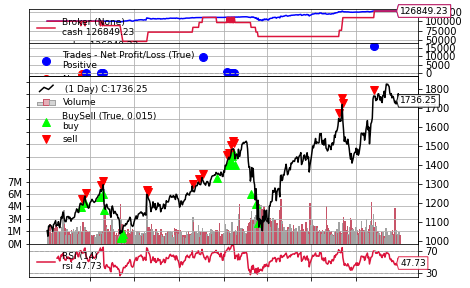

In [ ]:
cerebro_rsi = bt.Cerebro() #Initialise the bot

#add the strategy
cerebro_rsi.addstrategy(RSIStrategy)
#sets the sub-folder from where data feed will be collected
datapath = 'GOOGL.csv'
#set the data feed
data = bt.feeds.PandasData(dataname=yf.download('GOOGL', '2019-01-01', '2020-12-31'))

cerebro_rsi.adddata(data) #add data feed to engine

cerebro_rsi.broker.setcash(100000.0) #Set initial portfolio size
cerebro_rsi.broker.setcommission(commission=0.001) #Broker commission set as 0.1%
cerebro_rsi.addsizer(bt.sizers.FixedSize, stake = 10) #No of shares transacted during an order, can be manually specified in the buy() or sell() function
initial = cerebro_rsi.broker.get_value()
print('INITIAL PORTFOLIO VALUE: ',initial) #print initial portfolio value
cerebro_rsi.run()
final = cerebro_rsi.broker.get_value()
print('\n\nFINAL PORTFOLIO VALUE: ',final) #print final portfolio value
print('PROFIT: ', (final - initial)*100/initial, '%') #print profit
figure = plt.gcf()
figure.set_size_inches(10,5)
cerebro_rsi.plot()[0][0].savefig('figure_RSI.png', dpi=300) #save figure as image file